In [1]:
import numpy as np
import pandas as pd
from sklearn import cross_validation, linear_model, preprocessing,feature_extraction,\
metrics, model_selection,ensemble,svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import VarianceThreshold,SelectKBest,SelectFromModel
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import time

/Users/grisha.oryol/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/grisha.oryol/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
VALUE_COUNTS_THRESHOLD=50
RARE_CATEGORIES_THRESHOLD=0.0
SKEW_THRESHOLD=2
VARIANCE_THRESHOLD=0.0
CORRELATION_THRESHOLD=0.99
NAN_THRESHOLD=0.6
N_BINS=10

In [188]:
def list_most_correlated(df,threshold):
    corr_tab=df.corr()
    lst=[[corr_tab[x][y],x,y] for x in df.columns for y in df.columns if ((x>y) and (np.abs(corr_tab[x][y])>threshold))]
    lst.sort(key=lambda x: abs(x[0]))
    return lst

def fill_nan(data):
    
    print("filling the NaNs...")
    
    with_nan_num=num_features[np.where(np.sum(data[num_features].isnull())!=0)[0]]
    no_nan_num=num_features[np.where(np.sum(data[num_features].isnull())==0)[0]]
    with_nan_obj=obj_features[np.where(np.sum(data[obj_features].isnull())!=0)[0]]
    no_nan_obj=obj_features[np.where(np.sum(data[obj_features].isnull())==0)[0]]
    for_prediction=pd.concat([pd.get_dummies(data[no_nan_obj]),data[no_nan_num]],axis=1)
    for nm in with_nan_num:
        print('filling '+nm)
        model=ensemble.RandomForestRegressor()
        model.fit(for_prediction.iloc[np.where(~data[nm].isnull())[0],:],data[nm].iloc[np.where(~data[nm].isnull())[0]])
        data[nm].iloc[np.where(data[nm].isnull())[0]]=model.predict(for_prediction.iloc[np.where(data[nm].isnull())[0],:])
    
    #in the categorical columns with too many nan's
    many_nan_features=obj_features[np.where(data[obj_features].isnull().apply(np.mean)>NAN_THRESHOLD)]
    data[many_nan_features]=data[many_nan_features].applymap(lambda x:('NAAN' if pd.isnull(x) else x))
    
    #in the categorical columns
    no_nan=data[num_features].columns[np.where(np.sum(data[num_features].isnull())==0)]
    with_nan=obj_features[np.where(np.sum(data[obj_features].isnull())!=0)]
    print('using RF classifier to fill {} features in categorical variables'.format(len(with_nan)))
    for nm in with_nan:
        model=ensemble.RandomForestClassifier()
        model.fit(data[no_nan].iloc[np.where(~data[nm].isnull())[0],:],data[nm][~data[nm].isnull()])
        prediction=model.predict(data[no_nan].iloc[np.where(data[nm].isnull())[0],:])
        data[nm][data[nm].isnull()]=prediction
#       data[obj_features]=data[obj_features].fillna(method='ffill').fillna(method='bfill')
    print("number of NaN elements left:",data.isnull().apply(sum).sum())
    #return(data)


def merge_rare_categories(data):
    
    print('merging rare categories..')
    for cat in obj_features:
        vc=data[cat].value_counts()
        #if np.sum(vc<np.max(vc)*0.05)>0:
         #   print('in',cat,' merging ',np.sum(vc<np.max(vc)*0.05),'categories into "Other"' )
        global vc1
        vc1=vc
        #print(vc)
        diction={ind:('Other' if vc.loc[ind]<np.max(vc)*RARE_CATEGORIES_THRESHOLD else ind) for ind in vc.index}       
        data[cat]=data[cat].map(diction)
    
def clean_data(data):
    
    is_submit=data.IsSubmit
    del data['IsSubmit']
    
    print("initial dimensions are {}".format(data.shape))
 
    global output_mean, output_std
    #output_mean=np.mean(np.log(data['SalePrice']))
    #output_std=np.std(np.log(data['SalePrice']))
    
    output=np.log(data['SalePrice'])#-output_mean)/output_std
    del data['SalePrice']

    #numerical and categorical variables
    global obj_features,num_features
    obj_features=data.columns[data.dtypes=='object']
    num_features=data.columns[data.dtypes!='object']
    num_features=num_features[(num_features!='Id') & (num_features!='SalePrice')]
    
    #transform some numerical to categorical
    num_to_obj=num_features[np.where(data[num_features].apply(lambda x: len(pd.Series.value_counts(x)))<VALUE_COUNTS_THRESHOLD)[0]]
    print('transfering {} features from numerical to categorical'.format(len(num_to_obj)))
    obj_features=obj_features.append(num_to_obj)
    num_features=num_features.drop(num_to_obj)
    for nm in num_to_obj:
        data[nm]=data[nm]-np.min(data[nm])
    print("now {} numerical, {} categorical".format(len(num_features),len(obj_features)))
    
    # fill the NANs
    fill_nan(data)
    
    #add categorical variables - bins of numerical
    data_bins=data[num_features].apply(lambda x: pd.cut(x,labels=False,
            bins=sorted(set(np.percentile(x,np.concatenate([np.array([0]),np.arange(N_BINS)+1])*100/float(N_BINS)))),include_lowest=True))
    data_bins.columns=[nm+"_bins" for nm in num_features]
    data_bins=data_bins.astype('string')
    data=pd.concat([data,data_bins],axis=1)
    obj_features=obj_features.append(data_bins.columns)
    print("added {} bin variables".format(data_bins.shape[1]))
    
    print('any null? ',np.any(data.isnull()))
   

    # merge rare categories
    
    merge_rare_categories(data)

        
    #generate dummy variables
    print("generating dummy variables...")
    global dt
    dt=data
    dummies=pd.get_dummies(data[obj_features])
    print('obtained {} dummies from {} features'.format(dummies.shape[1],len(obj_features)))
    #print('any null? ',np.any(data[obj_features].isnull()))
    #dv=feature_extraction.DictVectorizer(sparse=False)
    #df=pd.DataFrame(data[obj_features])
    #out=dv.fit_transform(df.to_dict(orient='records'))
    #dummies0=pd.DataFrame(out,columns=dv.feature_names_)
    
    #print('any null? ',np.any(dummies0.isnull()))
    
    #encoder=preprocessing.OneHotEncoder(sparse=False)
    #dummies=pd.DataFrame(encoder.fit_transform(dummies0))
    
    #get rid of low variance variables
    print("dropping the low variance variables...")
    variance_selector=VarianceThreshold(VARIANCE_THRESHOLD)
    
    obj_red=pd.DataFrame(variance_selector.fit_transform(dummies),
                        columns=dummies.columns[variance_selector.get_support(True)])
    print("       dropped {} categorical features...".format(dummies.shape[1]-obj_red.shape[1]))
    num_red=pd.DataFrame(variance_selector.fit_transform(data[num_features]),
                        columns=data[num_features].columns[variance_selector.get_support(True)])
    print("       dropped {} numerical features...".format(len(num_features)-num_red.shape[1]))
    #merge numerical and categorical
    data_red=pd.concat([num_red,obj_red],axis=1)
    
    #log transform
    ind_large_skew = np.where(data_red.apply(pd.Series.skew)>SKEW_THRESHOLD)[0]
    data_red.iloc[:,ind_large_skew] = (data_red.iloc[:,ind_large_skew].apply(lambda x: np.log(x-np.min(x)+1)))
    
    data_red['GrLivArea2']=data_red.GrLivArea**2
    data_red['TotalBsmtSF2']=data_red.TotalBsmtSF**2
    data_red['LotFrontage2']=data_red.LotFrontage**2
    data_red['LotArea2']=data_red.LotArea**2
    data_red['YearBuilt2']=data_red.YearBuilt**2
    num_features=num_features.append(pd.Index(['GrLivArea2','TotalBsmtSF2','LotFrontage2','LotArea2','YearBuilt2']))
    
    #remove correlated
    print('calculating the correlation matrix...')
    correlated=list_most_correlated(data_red,CORRELATION_THRESHOLD)
    print('dropping {} variables'.format(len(correlated)))
    data_red=data_red.drop([x[1] for x in correlated],axis=1)
    
    
    return(data_red,output,is_submit) 

In [189]:
def rescale_pca(X_train,X_test,data_submit_red,y_train,y_test):
    global X_scaler,y_scaler
    X_scaler=preprocessing.StandardScaler()
    X_scaler.fit(X_train)
    X_train_new=pd.DataFrame(X_scaler.transform(X_train),columns=X_train.columns)
    X_test_new=pd.DataFrame(X_scaler.transform(X_test),columns=X_test.columns)
    data_submit_red_new=pd.DataFrame(X_scaler.transform(data_submit_red),columns=data_submit_red.columns)
    
    #PCA
    # pca=PCA()
    #pca.fit(X_train_new)
    #X_train_new=pd.DataFrame(pca.transform(X_train_new))
    #X_test_new=pd.DataFrame(pca.transform(X_test_new))
    #data_submit_red_new=pd.DataFrame(pca.transform(data_submit_red_new))

    y_scaler=preprocessing.StandardScaler()
    y_scaler.fit(y_train.values.reshape(-1,1))
    y_train_new=y_scaler.transform(y_train.values.reshape(-1,1))
    y_test_new=y_scaler.transform(y_test.values.reshape(-1,1))
    return (X_train_new,X_test_new,data_submit_red_new,y_train_new,y_test_new)

In [190]:
data=pd.read_csv("train.csv")
data['IsSubmit']=0
data_submit=pd.read_csv("test.csv")
data_submit['IsSubmit']=1
data_submit['SalePrice']=np.nan
data_total=pd.concat([data,data_submit])

In [191]:
data_total_red, output_total,is_submit = clean_data(data_total)
data_submit_red=data_total_red.copy().iloc[np.where(is_submit==1)[0],:]
data_red=data_total_red.copy().iloc[np.where(is_submit==0)[0],:]
output=output_total.copy().iloc[np.where(is_submit==0)[0]]
print(data_red.shape)

initial dimensions are (2919, 81)
transfering 18 features from numerical to categorical
now 18 numerical, 61 categorical
filling the NaNs...
filling BsmtFinSF1
filling BsmtFinSF2
filling BsmtUnfSF
filling GarageArea
filling GarageYrBlt
filling LotFrontage
filling MasVnrArea
filling TotalBsmtSF
using RF classifier to fill 22 features in categorical variables


/Users/grisha.oryol/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


('number of NaN elements left:', 0)
added 18 bin variables
('any null? ', False)
merging rare categories..
generating dummy variables...
obtained 406 dummies from 79 features
dropping the low variance variables...
       dropped 1 categorical features...
       dropped 0 numerical features...
calculating the correlation matrix...
dropping 6 variables
(1460, 422)


## Fit with Elastic Net

In [2]:
REPEATS=10
time_start=time.time()
train_error=np.zeros(REPEATS)
test_error=np.zeros(REPEATS)
for cut_off in [2,2.5,3]:
     for step in range(REPEATS):

        X_train_old, X_test_old ,y_train_old, y_test_old = cross_validation.train_test_split(data_red,output,test_size=0.40)
        X_train, X_test, data_submit_red, y_train, y_test = rescale_pca(X_train_old,X_test_old,data_submit_red,y_train_old,y_test_old)
        #clf=ensemble.IsolationForest(max_features=X_train.shape[1])
        #clf.fit(X_train)
        #X_train_filtered=X_train.loc[(clf.predict(X_train)==1),:]
        #y_train_filtered=y_train[clf.predict(X_train)==1]
        #alpha = 0.55 and lambda = 0.006552937
        X_train_filtered=X_train
        y_train_filtered=y_train

        model_cv_glm=linear_model.ElasticNetCV(l1_ratio=[0.005,0.01,0.02,0.05,0.1,0.3,0.5,0.7,1],cv=5)#(l1_ratio=np.arange(1,10)*0.001,n_alphas=100,n_jobs=-1,verbose=True)
        model_cv_glm.fit(X_train,y_train)

        pred_train_glm=y_scaler.inverse_transform(np.ravel(model_cv_glm.predict(X_train)))
        pred_test_glm=y_scaler.inverse_transform(np.ravel(model_cv_glm.predict(X_test)))

        upper_limit=np.mean(pred_train_glm)+cut_off*np.std(pred_train_glm)
        lower_limit=np.mean(pred_train_glm)-cut_off*np.std(pred_train_glm)
        pred_test_glm_cutoff=[max(min(x,upper_limit),lower_limit) for x in pred_test_glm]
        train_error[step]=metrics.mean_squared_error(pred_train_glm,y_train_old)**0.5
        test_error[step]=metrics.mean_squared_error(pred_test_glm_cutoff,y_test_old)**0.5

        print(train_error[step],test_error[step],X_train.shape,model_cv_glm.l1_ratio_,model_cv_glm.alpha_)


    print(np.mean(test_error))
    print(np.std(test_error))
print(time.time()-time_start)

In [174]:
metrics.mean_squared_error(pred_test_glm_cutoff,y_test_old)**0.5

0.13153623305380327

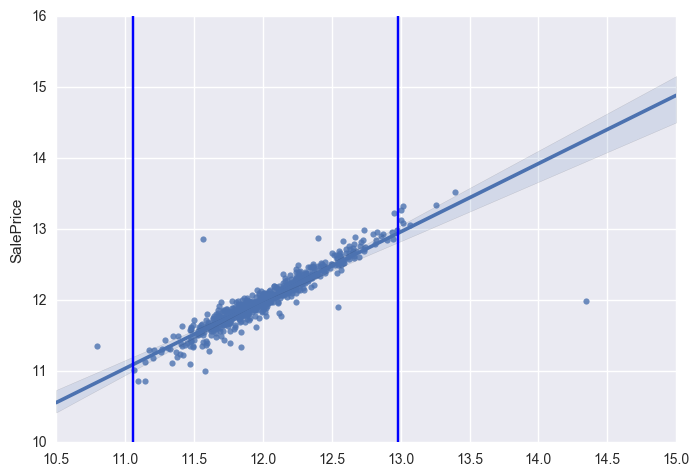

In [175]:
sns.regplot(pred_test_glm, y_test_old)
plt.axvline(np.mean(pred_test_glm)+2.5*np.std(pred_test_glm))
plt.axvline(np.mean(pred_test_glm)-2.5*np.std(pred_test_glm))
plt.show()

In [1]:
#New table, nbins=5:
#nan_th==0.6, no PCA, rare categories=0
#0.00779173930691+-0.00769042029739
#0.00772961502965+-0.00741394916207
#0.00679230764584+-0.00670672410188
#nbins=10:
#0.00480558928783+-0.0100353159795
#0.00435357166519+-0.00796496419725
#0.00483450878802+-0.00743449098978

In [ ]:
# New table, nbins=20:
# nan_th==0.6, no PCA, rare categories=0
#     0.00844258084414+-0.00743448177053
#     0.00307019816589+-0.00639998967546
#     0.0074037660509+-0.00922942748243
# nan_th==0.6, no PCA, rare categories=0.1
#     0.0125325531611+-0.0035643335253
#     0.0203508840996+-0.00802435447416
#     0.017291177258+-0.00363447567437
# nan_th==0.6, no PCA, rare categories=0.01
#     0.00745101751965+-0.0096584663673
#     0.00763338806598+-0.00907128695238
#     0.00696099561394+-0.00768448301691
# nan_th==0.6, no PCA, rare categories=0.05
#     0.0124317159524+-0.00445658054852
  

In [3]:
# Nan threshold==0.3
# without PCA: 0.123017070529+-0.0065760505002
#              0.130509789317+-0.00451969202433
#              0.131860238182+-0.00554806971468
# with PCA,no components:    
#              0.134126863431+-0.00709385668958
#              0.132370303728+-0.0103441635164
# with PCA(0.9):
#              0.13122588549+-0.00368965566784
#              0.137993746855+-0.00417599206008
# with PCA(0.7):
#              0.139162646211+-0.00601422907791
#              0.14084307537+-0.00515980078075
# nan_threshold==0.001, no pca
#              0.124976211125+-0.00741292235244
#              0.129322560145+-0.00570338683201
#              0.122662428442+-0.00826018167768
#              0.124292996935+-0.00781120334737
#              0.127625241541+-0.00699194764589
# nan_threshold==0, no pca
#              0.129461318877+-0.00822403667756
#              0.128659743833+-0.0064321293664
#              0.127906991886+-0.00975079871208
#              0.125723798566+-0.00711324296677
#              0.126334458198+-0.00818082287048
#              0.13032187205+-0.00502903233845
#              0.128988038561+-0.00725733722623
# nan_threshold==0.01:
#              0.12621060956+-0.00618528247349
#              0.122764423245+-0.00730523789536
# nan_threshold==0.1:
#             0.126889830715+-0.00820764130419
#             0.123122413114+-0.00801152371001
#             0.123810143029+-0.00572375542766
# nan_threshold==0.3:
#             0.124399939086+-0.00986437410852
#             0.123998382707+-0.00950439232803
#             0.121579070675+-0.00703288359292
# nan_threshold==0.6:
#             0.120301818847+-0.00919325177554

## Bagging Regressor

In [167]:
REPEATS=5
errs=list(np.repeat((0,0,0),REPEATS))
for step in range(REPEATS):
    X_train_old, X_test_old ,y_train_old, y_test_old = cross_validation.train_test_split(data_red,output,test_size=0.40)
    X_train, X_test, data_submit_red, y_train, y_test = rescale_pca(X_train_old,X_test_old,data_submit_red,y_train_old,y_test_old)
    base_model=linear_model.ElasticNetCV(l1_ratio=[0.01,0.1,0.5,0.9])
    model=ensemble.BaggingRegressor(base_estimator=base_model,n_estimators=10,oob_score=False,n_jobs=1,verbose=True)
    model.fit(X_train,np.ravel(y_train))
    cut_off=2.5
    bag_pred_test=y_scaler.inverse_transform(model.predict(X_test))
    bag_pred_train=y_scaler.inverse_transform(model.predict(X_train))
    upper_limit=np.mean(bag_pred_train)+cut_off*np.std(bag_pred_train)
    lower_limit=np.mean(bag_pred_train)-cut_off*np.std(bag_pred_train)
    bag_pred_test_cutoff=[max(min(x,upper_limit),lower_limit) for x in bag_pred_test]
    errs[step]=(np.mean((bag_pred_train-y_train_old)**2)**0.5,
          np.mean((bag_pred_test_cutoff-y_test_old)**2)**0.5, np.mean((bag_pred_test-y_test_old)**2)**0.5)
    print(errs[step])

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


(0.09286307838846904, 0.11751985951082401, 0.11626157053028255)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


(0.09157062547922336, 0.12938489046608798, 0.15609847600210222)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


(0.08327510862966377, 0.13126727052862566, 0.17873523480006387)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


(0.0835403265038212, 0.12813337210449044, 0.17620505780988857)
(0.10171918850481534, 0.12889260304461364, 0.1264666346733431)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [168]:
errs

[(0.09286307838846904, 0.11751985951082401, 0.11626157053028255),
 (0.09157062547922336, 0.12938489046608798, 0.15609847600210222),
 (0.08327510862966377, 0.13126727052862566, 0.17873523480006387),
 (0.0835403265038212, 0.12813337210449044, 0.17620505780988857),
 (0.10171918850481534, 0.12889260304461364, 0.1264666346733431),
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [166]:
errs1

[(0.09720298454047759, 0.13238209267055245, 0.132885954865008),
 (0.08744232104731571, 0.1354136818783271, 0.17482767483470588),
 (0.08861185511844714, 0.13679714575422414, 0.177857668233409),
 (0.10263834926483917, 0.1292898036573011, 0.1271990187263639),
 (0.09097532080975887, 0.13331818569912834, 0.17180299862920714),
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [160]:
errs0

[(0.09860786614032349, 0.11779789218415768, 0.11529748636591192),
 (0.09964225863828324, 0.11393788178668375, 0.11055946593816993),
 (0.0975384475950869, 0.12813548917263046, 0.12505469636675223),
 (0.09202960181393383, 0.1284342500762307, 0.12988004639282347),
 (0.10475985039889789, 0.10974593800487555, 0.10559311460484776),
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

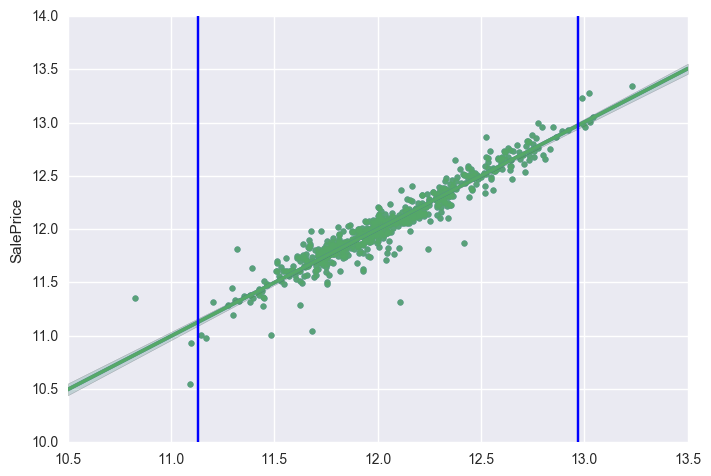

In [19]:
sns.regplot(bag_pred_test, y_test_old)
plt.axvline(np.mean(bag_pred_test)+2.5*np.std(bag_pred_test))
plt.axvline(np.mean(bag_pred_test)-2.5*np.std(bag_pred_test))
plt.show()

2

## Fit on all the data

In [169]:
def rescale_pca_final(X_data,X_submit,y):
    global X_scaler,y_scaler
    X_scaler=preprocessing.StandardScaler()
    X_scaler.fit(X_data)
    X_data_new=pd.DataFrame(X_scaler.transform(X_data),columns=X_data.columns)
    X_submit_new=pd.DataFrame(X_scaler.transform(X_submit),columns=X_submit.columns)
    #PCA
    #pca=PCA()
    #pca.fit(X_train)
    #X_train=pca.transform(X_train)
    #X_test=pca.transform(X_test)
    #data_submit_red=pca.transform(data_submit_red)
    
    y_scaler=preprocessing.StandardScaler()
    y_scaler.fit(y.values.reshape(-1,1))
    y_new=y_scaler.transform(y.values.reshape(-1,1))
    return (X_data_new,X_submit_new,y_new)

In [170]:
del y_scaler
del X_scaler

In [192]:
data_red_scaled, data_submit_red_scaled, output_scaled = rescale_pca_final(data_red,data_submit_red,output)

In [195]:
base_model=linear_model.ElasticNetCV(l1_ratio=[0.01,0.1,0.5,0.9])
model=ensemble.BaggingRegressor(base_estimator=base_model,n_estimators=50,oob_score=False,n_jobs=1,verbose=True)
model.fit(data_red_scaled,output_scaled)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min finished


BaggingRegressor(base_estimator=ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=[0.01, 0.1, 0.5, 0.9], max_iter=1000, n_alphas=100,
       n_jobs=1, normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=50, n_jobs=1, oob_score=False,
         random_state=None, verbose=True, warm_start=False)

In [196]:
bag_pred_data=y_scaler.inverse_transform(model.predict(data_red_scaled))
bag_pred_submit=y_scaler.inverse_transform(model.predict(data_submit_red_scaled))

cut_off=2.5   
upper_limit=np.mean(bag_pred_data)+cut_off*np.std(bag_pred_data)
lower_limit=np.mean(bag_pred_data)-cut_off*np.std(bag_pred_data)
bag_pred_data_cutoff=pd.Series([max(min(x,upper_limit),lower_limit) for x in bag_pred_data])

upper_limit=np.mean(bag_pred_submit)+cut_off*np.std(bag_pred_submit)
lower_limit=np.mean(bag_pred_submit)-cut_off*np.std(bag_pred_submit)
bag_pred_submit_cutoff=pd.Series([max(min(x,upper_limit),lower_limit) for x in bag_pred_submit])

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


In [197]:
np.mean((bag_pred_data-output)**2)**0.5

0.09930586336818124

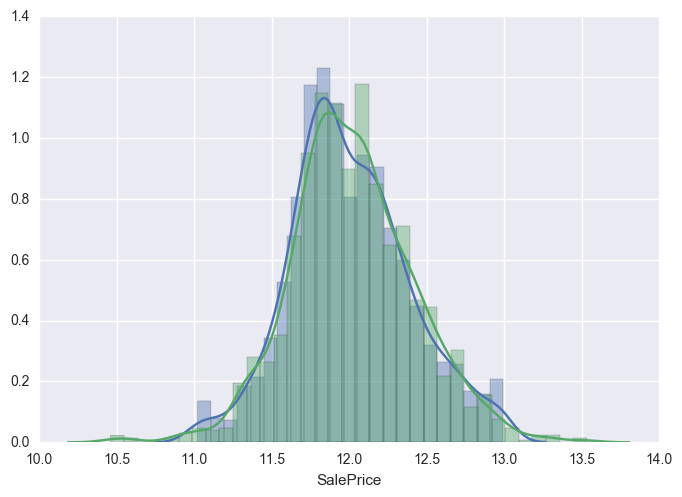

In [202]:
sns.distplot(bag_pred_submit_cutoff)
sns.distplot(output)
plt.show()

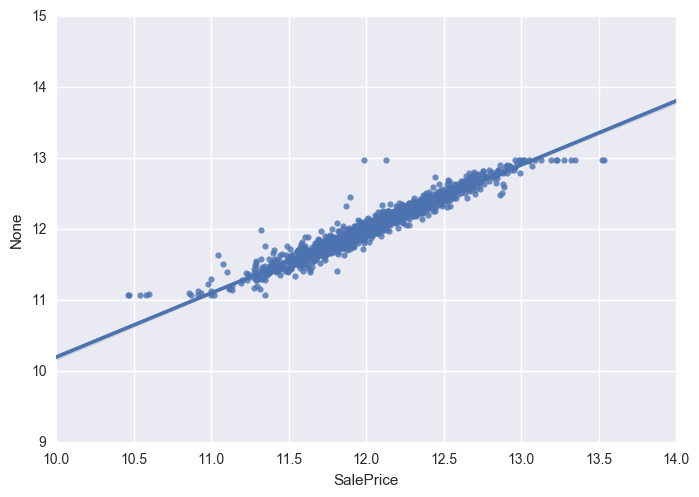

In [199]:
sns.regplot(output,bag_pred_data_cutoff)
plt.show()

In [203]:
final=pd.DataFrame(pd.concat([data_submit.Id,pd.DataFrame(np.exp(bag_pred_submit_cutoff))[0]],axis=1))
final.columns=['Id','SalePrice']
final.to_csv("output.csv",index=False)
final

,Id,SalePrice
0,1461,124214.528482
1,1462,151220.426135
2,1463,182587.712951
3,1464,195705.838788
4,1465,197810.742375
5,1466,174150.433309
6,1467,179301.344368
7,1468,168222.867016
8,1469,183127.681241
9,1470,120733.559648


## Something else

In [2400]:
time_start=time.time()
X_train, X_test ,y_train, y_test = cross_validation.train_test_split(data_red,output,test_size=0.40)
X_train_filtered=X_train
y_train_filtered=y_train

model_cv_glm=linear_model.ElasticNetCV(l1_ratio=[0.001,0.005,0.01,0.02,0.05,0.07,0.1,0.3,0.5,0.6,0.7,0.8,0.9,1])#(l1_ratio=np.arange(1,10)*0.001,n_alphas=100,n_jobs=-1,verbose=True)
model_cv_glm.fit(X_train_filtered,y_train_filtered)

pred_train_glm_filtered=model_cv_glm.predict(X_train_filtered)
pred_test_glm=model_cv_glm.predict(X_test)

tr_error=output_std*metrics.mean_squared_error(pred_train_glm_filtered,y_train_filtered)**0.5
test_error=output_std*metrics.mean_squared_error([max(min(x,3),-3) for x in pred_test_glm],y_test)**0.5
test_error_no_filter=output_std*metrics.mean_squared_error(pred_test_glm,y_test)**0.5


print(tr_error,test_error,test_error_no_filter,X_train_filtered.shape,model_cv_glm.l1_ratio_,model_cv_glm.alpha_)

print(time.time()-time_start)

(0.10025105743884477, 0.11865579705631921, 0.13856898251743954, (876, 421), 0.050000000000000003, 0.16282228789402986)
9.70093989372


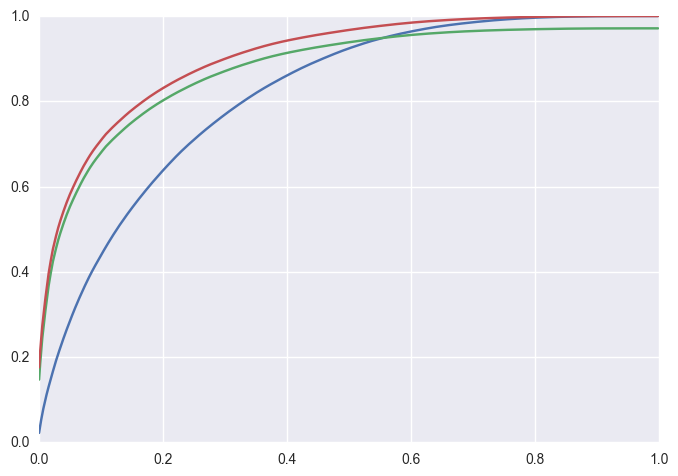

In [2175]:
from scipy.stats import norm
arr=norm.rvs(size=len(y_test))**2
plt.plot(np.arange(len(arr))/float(len(arr)),np.cumsum(sorted(arr,reverse=True))/sum(arr))
plt.plot(np.arange(len(y_test))/float(len(y_test)),np.cumsum(sorted((np.array([max(min(x,3),-3) for x in pred_test_glm-y_test]))**2,reverse=True))/sum(sorted((pred_test_glm-y_test)**2,reverse=True)))
plt.plot(np.arange(len(y_test))/float(len(y_test)),np.cumsum(sorted((pred_test_glm-y_test)**2,reverse=True))/sum(sorted((pred_test_glm-y_test)**2,reverse=True)))

plt.show()


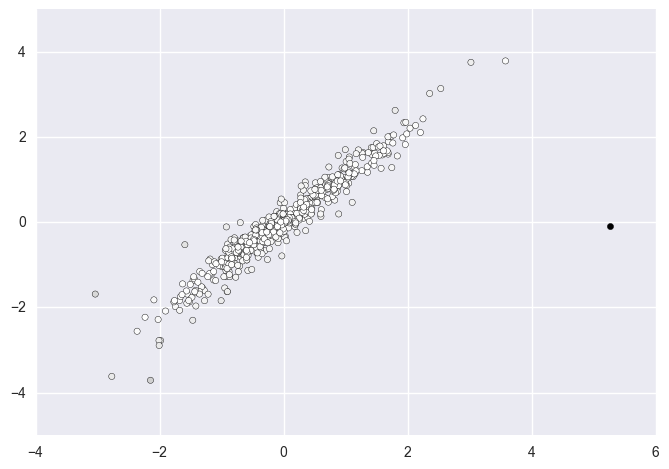

In [2401]:
plt.scatter([x for x in pred_test_glm],y_test-0*pred_test_glm,c=abs(y_test-pred_test_glm))
plt.show()

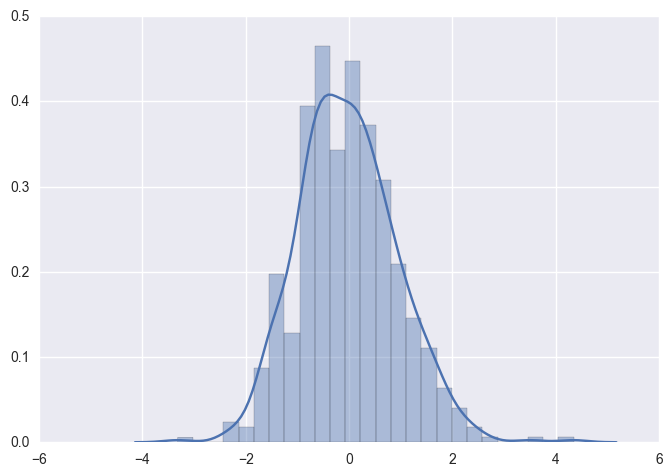

In [7]:
sns.distplot(model_cv_glm.predict(X_test))
plt.show()

In [2405]:
X_train2=X_train.copy()
X_test2=X_test.copy()

In [2420]:
X_train2['Approx']=model_cv_glm.predict(X_train)
y_train2=(y_train-model_cv_glm.predict(X_train))*output_std

err_mean=np.mean(y_train2)
err_std=np.std(y_train2)
y_train2=(y_train2-err_mean)/err_std

X_test2['Approx']=model_cv_glm.predict(X_test)
y_test2=(y_test-model_cv_glm.predict(X_test))*output_std
y_test2=(y_test2-err_mean)/err_std

In [2424]:
y_train2.std()

1.000571265399351

In [2415]:
print(np.sqrt(np.mean(((y_test-model_cv_glm.predict(X_test))*output_std)**2)),
np.sqrt(np.mean(((y_test-np.array([max(min(x,2.5),-2.5) for x in model_cv_glm.predict(X_test)]))*output_std)**2)))

(0.13856898251743949, 0.11714113468711373)


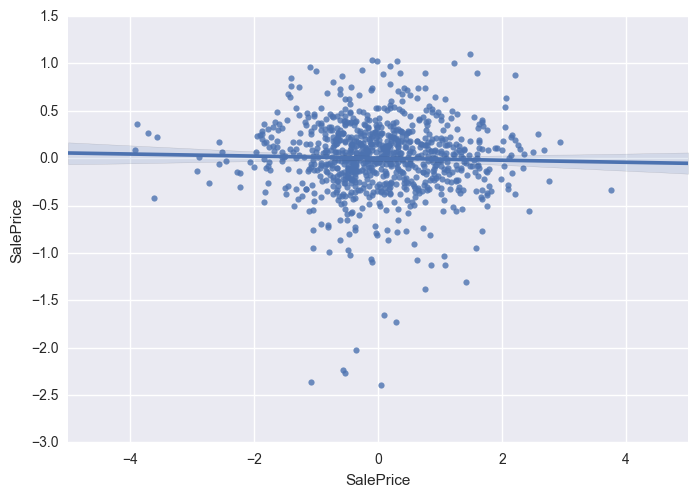

In [2155]:
sns.regplot(y_train,y_train2)
plt.show()

## Fit with Random Forest

In [2435]:
time_start=time.time()
model=ensemble.RandomForestRegressor(n_jobs=-1)
params={'n_estimators':[10,50,70,100],'max_depth':[2,3,5,10],'max_features':['sqrt']}
model_cv_rf=model_selection.GridSearchCV(model,params)
model_cv_rf.fit(X_train2,y_train2)
print(time.time()-time_start)
model_cv_rf.best_params_

24.8964591026


{'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 10}

In [2436]:
pred_train_rf=model_cv_rf.predict(X_train2)
pred_test_rf=model_cv_rf.predict(X_test2)

In [2437]:
print(err_std*metrics.mean_squared_error(pred_train_rf,y_train2)**0.5,
      err_std*metrics.mean_squared_error(pred_test_rf,y_test2)**0.5)
print(output_std*metrics.mean_squared_error(X_train2['Approx'],y_train)**0.5,
      output_std*metrics.mean_squared_error(X_test2['Approx'],y_test)**0.5)
print(metrics.mean_squared_error(err_std*pred_train_rf+err_mean+output_std*X_train2['Approx'],output_std*y_train)**0.5,
      metrics.mean_squared_error(err_std*pred_test_rf+err_mean+output_std*X_test2['Approx'],output_std*y_test)**0.5)

(0.097163920819955771, 0.13281848508463218)
(0.10025105743884477, 0.13856898251743954)
(0.097163920819955785, 0.13281848508463215)


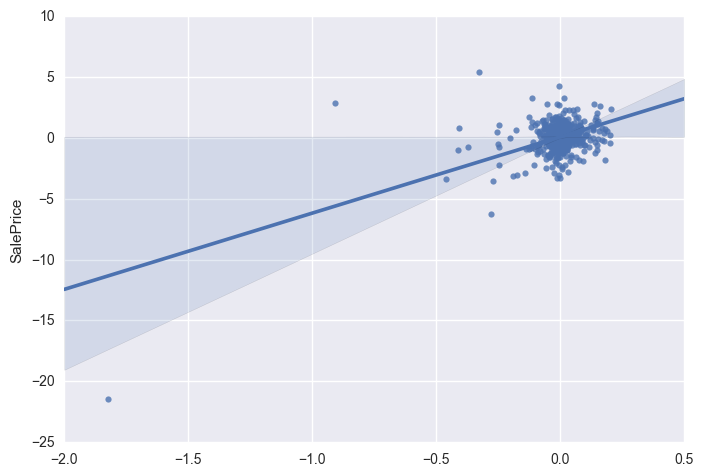

In [2433]:
sns.regplot(pred_test_rf,y_test2)
plt.show()

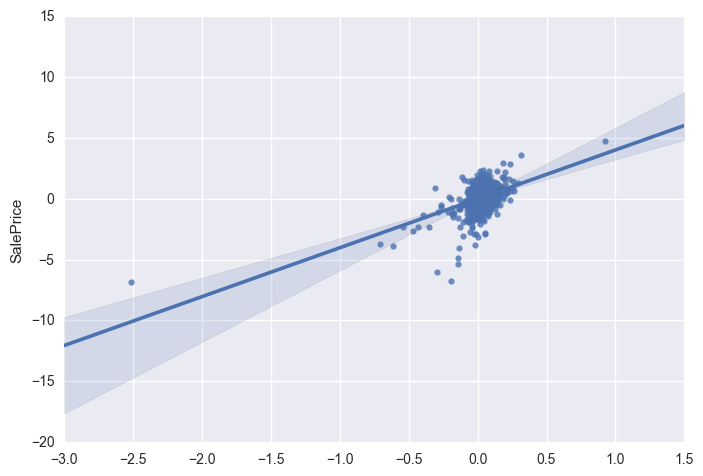

In [2434]:
sns.regplot(pred_train_rf,y_train2)
plt.show()

## Gradient Boosting Regressor

In [2535]:
model=ensemble.GradientBoostingRegressor(n_estimators=500,learning_rate=0.05,max_leaf_nodes=10)
model.fit(X_train2,y_train2)
gbm_pred_train2=model.predict(X_train2)
gbm_pred_test2=model.predict(X_test2)
print(err_std*metrics.mean_squared_error(gbm_pred_train2,y_train2),
     err_std*metrics.mean_squared_error(gbm_pred_test2,y_test2))

(0.0090499287100180379, 0.16135876577381822)


In [2543]:
y_test2.mean()

0.03297787412693601

In [2536]:
staged_predict_test=[err_std*metrics.mean_squared_error(x,y_test2) for x in model.staged_predict(X_test2)]
staged_predict_train=[err_std*metrics.mean_squared_error(x,y_train2) for x in model.staged_predict(X_train2)]

In [2540]:
help(model)

Help on GradientBoostingRegressor in module sklearn.ensemble.gradient_boosting object:

class GradientBoostingRegressor(BaseGradientBoosting, sklearn.base.RegressorMixin)
 |  Gradient Boosting for regression.
 |  
 |  GB builds an additive model in a forward stage-wise fashion;
 |  it allows for the optimization of arbitrary differentiable loss functions.
 |  In each stage a regression tree is fit on the negative gradient of the
 |  given loss function.
 |  
 |  Read more in the :ref:`User Guide <gradient_boosting>`.
 |  
 |  Parameters
 |  ----------
 |  loss : {'ls', 'lad', 'huber', 'quantile'}, optional (default='ls')
 |      loss function to be optimized. 'ls' refers to least squares
 |      regression. 'lad' (least absolute deviation) is a highly robust
 |      loss function solely based on order information of the input
 |      variables. 'huber' is a combination of the two. 'quantile'
 |      allows quantile regression (use `alpha` to specify the quantile).
 |  
 |  learning_rat

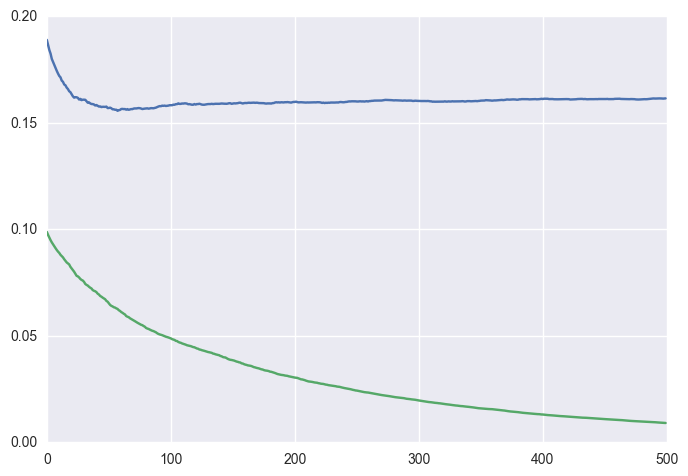

In [2538]:
plt.plot(staged_predict_test)
plt.plot(staged_predict_train)
plt.show()

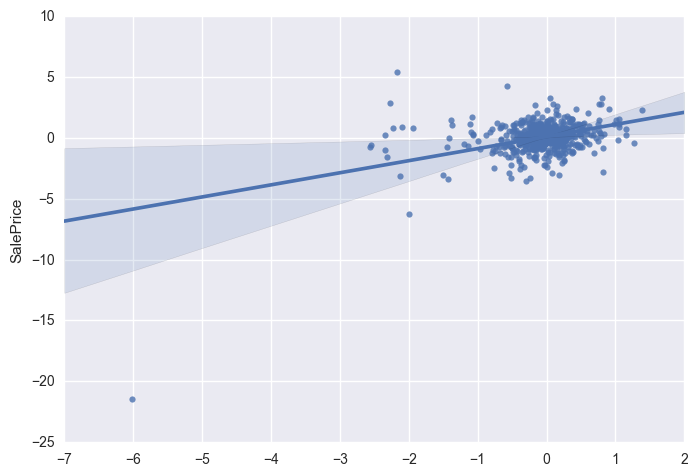

In [2539]:
sns.regplot(gbm_pred_test2,y_test2)
plt.show()

## Fit with SVM

In [2136]:
model_svm=svm.SVR()
params={'C':[0.01,0.5,0.1,0.2,0.5,1],'kernel':['rbf','poly','linear'],'shrinking':[True,False],'epsilon':[0.05,0.1,0.5,0.7,1]}
model_cv_svm=model_selection.GridSearchCV(model_svm,params)

In [2137]:
model_cv_svm.fit(X_train2,y_train2)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'kernel': ['rbf', 'poly', 'linear'], 'C': [0.01, 0.5, 0.1, 0.2, 0.5, 1], 'shrinking': [True, False], 'epsilon': [0.05, 0.1, 0.5, 0.7, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [2138]:
predict_svm_test=model_cv_svm.predict(X_test2)
predict_svm_train=model_cv_svm.predict(X_train2)

In [2139]:
print(err_std*metrics.mean_squared_error(predict_svm_train,y_train2)**0.5,err_std*metrics.mean_squared_error(predict_svm_test,y_test2)**0.5)

(0.097330771176337094, 0.13845160236203954)


In [2142]:
model_cv_svm.best_params_

{'C': 0.1, 'epsilon': 0.5, 'kernel': 'rbf', 'shrinking': True}

## Predict for real

In [2402]:
#id_submit=data_submit_red
pred_submit=pd.DataFrame(np.array([max(min(x,3),-3) for x in model_cv_glm.predict(data_submit_red)])*output_std+output_mean)

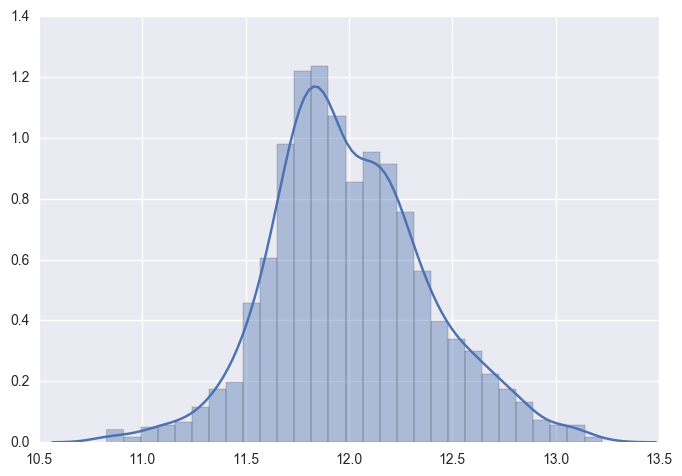

In [2403]:
sns.distplot(pred_submit)
plt.show()

In [2404]:
final=pd.DataFrame(pd.concat([data_submit.Id,np.exp(pred_submit)[0]],axis=1))
final.columns=['Id','SalePrice']
final.to_csv("output.csv",index=False)
final

,Id,SalePrice
0,1461,120557.081249
1,1462,149451.255828
2,1463,182017.588727
3,1464,200442.290247
4,1465,200930.037074
5,1466,177318.467297
6,1467,181096.983890
7,1468,168567.999081
8,1469,184643.496890
9,1470,122307.710038
